# Requirements

In [ ]:
# Add as many imports as you need.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the future **count of page loads**. To accomplish this use data from the past three days, which includes information such as the **count of page loads**, **count of unique visits**, **count of first time-visits**, and **count of returning visits**. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast the future **count of page loads** based on the provided historical data.

## The Website Visitors Dataset

## Downloading the Website Visitors Dataset

In [ ]:
!gdown 1h1P3NboXKbWNngqgCB1i4bHFRcv7uDJe

Downloading...
From: https://drive.google.com/uc?id=1h1P3NboXKbWNngqgCB1i4bHFRcv7uDJe
To: /content/website-visitors.csv
100% 92.8k/92.8k [00:00<00:00, 3.91MB/s]


## Exploring the Website Visitors Dataset
This datatset consists of daily counts of page loads, unique visitors, first-time visitors, and returning visitors for an academic teaching notes website. The dataset contains 2167 rows spanning from September 14, 2014, to August 19, 2020. A visit is defined as a series of hits on one or more pages by the same user on a given day, identified by IP address. Shared IP addresses are considered a single user. A visit is "unique" if a hit from the same IP address hasn't occurred within the last 6 hours. Returning visitors are identified by cookies, and the rest are classified as first-time visitors. The unique visitor count is the sum of returning and first-time visitors.

The dataset consists of the following columns:
- date - date in mm/dd/yyyy format,
- day_of_week - day of the week in text form (Monday, Tuesday, etc.),
- page_loads - daily number of pages loaded,
- unique_visits - daily number of visitors from IP addresses with no hits in over 6 hours,
- first_time_visits - number of unique visitors without a identifying cookie, and
- returning_visits - number of unique visitors minus first-time visitors.

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [ ]:
# Write your code here. Add as many boxes as you need.
data = pd.read_csv('/content/website-visitors.csv')

Explore the dataset using visualizations of your choice.

In [ ]:
# Write your code here. Add as many boxes as you need.
data

,date,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
0,9/14/2014,Sunday,2.146,1.582,1.430,152.0
1,9/15/2014,Monday,3.621,2.528,2.297,231.0
2,9/16/2014,Tuesday,3.698,2.630,2.352,278.0
3,9/17/2014,Wednesday,3.667,2.614,2.327,287.0
4,9/18/2014,Thursday,3.316,2.366,2.130,236.0
...,...,...,...,...,...,...
2162,8/15/2020,Saturday,2.221,1.696,1.373,323.0
2163,8/16/2020,Sunday,2.724,2.037,1.686,351.0
2164,8/17/2020,Monday,3.456,2.638,2.181,457.0
2165,8/18/2020,Tuesday,3.581,2.683,2.184,499.0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,10))
sns.heatmap(data.corr(),annot=True,cmap='hsv',fmt='.3f',linewidths=2)
plt.show()

array([[<Axes: title={'center': 'page_loads'}>,
        <Axes: title={'center': 'unique_visits'}>],
       [<Axes: title={'center': 'first_time_visits'}>,
        <Axes: title={'center': 'returning_visits'}>]], dtype=object)

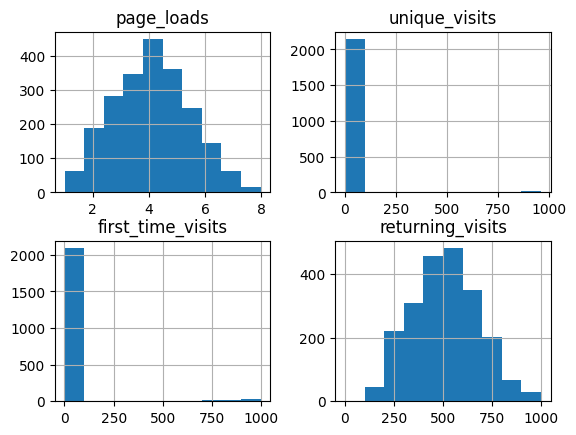

In [ ]:
data.hist()

Drop the column **day_of_week**, because we won't use it.

In [ ]:
# Write your code here. Add as many boxes as you need.
data = data.drop(['day_of_week'], axis = 1)

## Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

*Be careful when extracting the features. For each day, ensure that features are obtained sequentially, starting with those from 3 days ago, followed by features from 2 days ago, and finally, features from 1 day ago. This becomes crucial when reshaping the train and test sets later on.*

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [ ]:
# Write your code here. Add as many boxes as you need.
columns_to_shift = ['page_loads', 'unique_visits', 'first_time_visits', 'returning_visits']

In [ ]:
data

,date,page_loads,unique_visits,first_time_visits,returning_visits,3_lag_page_loads,3_lag_unique_visits,3_lag_first_time_visits,3_lag_returning_visits,2_lag_page_loads,2_lag_unique_visits,2_lag_first_time_visits,2_lag_returning_visits,1_lag_page_loads,1_lag_unique_visits,1_lag_first_time_visits,1_lag_returning_visits
0,9/14/2014,2.146,1.582,1.430,152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9/15/2014,3.621,2.528,2.297,231.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.146,1.582,1.430,152.0
2,9/16/2014,3.698,2.630,2.352,278.0,NaN,NaN,NaN,NaN,2.146,1.582,1.430,152.0,3.621,2.528,2.297,231.0
3,9/17/2014,3.667,2.614,2.327,287.0,2.146,1.582,1.430,152.0,3.621,2.528,2.297,231.0,3.698,2.630,2.352,278.0
4,9/18/2014,3.316,2.366,2.130,236.0,3.621,2.528,2.297,231.0,3.698,2.630,2.352,278.0,3.667,2.614,2.327,287.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,8/15/2020,2.221,1.696,1.373,323.0,3.767,2.904,2.477,427.0,3.621,2.780,2.322,458.0,2.971,2.308,1.922,386.0
2163,8/16/2020,2.724,2.037,1.686,351.0,3.621,2.780,2.322,458.0,2.971,2.308,1.922,386.0,2.221,1.696,1.373,323.0
2164,8/17/2020,3.456,2.638,2.181,457.0,2.971,2.308,1.922,386.0,2.221,1.696,1.373,323.0,2.724,2.037,1.686,351.0
2165,8/18/2020,3.581,2.683,2.184,499.0,2.221,1.696,1.373,323.0,2.724,2.037,1.686,351.0,3.456,2.638,2.181,457.0


In [ ]:
for col in [3,2,1]:  # Include lag 1, 2, and 3
    for feature in columns_to_shift:
        data[f'{col}_lag_{feature}'] = data[feature].shift(col)

In [ ]:
data = data.dropna()

In [ ]:
data = data.drop(columns=['date'])

In [ ]:
data

,page_loads,unique_visits,first_time_visits,returning_visits,3_lag_page_loads,3_lag_unique_visits,3_lag_first_time_visits,3_lag_returning_visits,2_lag_page_loads,2_lag_unique_visits,2_lag_first_time_visits,2_lag_returning_visits,1_lag_page_loads,1_lag_unique_visits,1_lag_first_time_visits,1_lag_returning_visits
3,3.667,2.614,2.327,287.0,2.146,1.582,1.430,152.0,3.621,2.528,2.297,231.0,3.698,2.630,2.352,278.0
4,3.316,2.366,2.130,236.0,3.621,2.528,2.297,231.0,3.698,2.630,2.352,278.0,3.667,2.614,2.327,287.0
5,2.815,1.863,1.622,241.0,3.698,2.630,2.352,278.0,3.667,2.614,2.327,287.0,3.316,2.366,2.130,236.0
6,1.658,1.118,985.000,133.0,3.667,2.614,2.327,287.0,3.316,2.366,2.130,236.0,2.815,1.863,1.622,241.0
7,2.288,1.656,1.481,175.0,3.316,2.366,2.130,236.0,2.815,1.863,1.622,241.0,1.658,1.118,985.000,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,2.221,1.696,1.373,323.0,3.767,2.904,2.477,427.0,3.621,2.780,2.322,458.0,2.971,2.308,1.922,386.0
2163,2.724,2.037,1.686,351.0,3.621,2.780,2.322,458.0,2.971,2.308,1.922,386.0,2.221,1.696,1.373,323.0
2164,3.456,2.638,2.181,457.0,2.971,2.308,1.922,386.0,2.221,1.696,1.373,323.0,2.724,2.037,1.686,351.0
2165,3.581,2.683,2.184,499.0,2.221,1.696,1.373,323.0,2.724,2.037,1.686,351.0,3.456,2.638,2.181,457.0


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [ ]:
# Write your code here. Add as many boxes as you need.
X, Y = data.drop(columns=['page_loads']), data['page_loads']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

## Feauture Scaling
Scale the extracted features using an appropriate scaler.

In [ ]:
# Write your code here. Add as many boxes as you need.
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [ ]:
# Write your code here. Add as many boxes as you need.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
X_train.shape

(1731, 15, 1)

## Long Short-Term Memory (LSTM) Network
Build a Long Short-Term Memory (LSTM) Network for forecasting the future **count of page loads** based on the extracted features from the previous three days.

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [ ]:
# Write your code here. Add as many boxes as you need.
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras

In [ ]:
# Write your code here. Add as many boxes as you need.
model = Sequential()
model.add(LSTM(100,  activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50,  activation='relu'))
model.add(Dense(1, activation='linear'))

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [ ]:
# Write your code here. Add as many boxes as you need.
model.compile(loss=keras.losses.MeanSquaredError() , optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError() ])

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [ ]:
# Write your code here. Add as many boxes as you need.
history = model.fit(X_train, Y_train, batch_size=16, validation_split=0.2, epochs=20, shuffle=False)

Epoch 1/20
87/87 [==============================] - 10s 49ms/step - loss: 0.0648 - mean_squared_error: 0.0648 - mean_absolute_error: 0.2049 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1616
Epoch 2/20
87/87 [==============================] - 4s 45ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1663 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1741
Epoch 3/20
87/87 [==============================] - 8s 89ms/step - loss: 0.0408 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1632 - val_loss: 0.0499 - val_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.1831
Epoch 4/20
87/87 [==============================] - 4s 46ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1624 - val_loss: 0.0534 - val_mean_squared_error: 0.0534 - val_mean_absolute_error: 0.1897
Epoch 5/20
87/87 [==============================] - 7s 80ms/step - loss: 0.0399 - mean_squared_erro

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

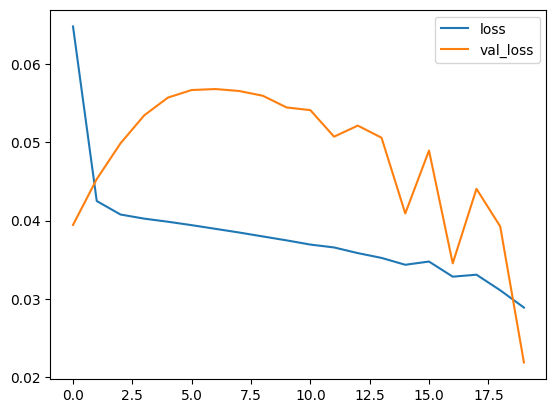

In [ ]:
# Write your code here. Add as many boxes as you need.
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

Use the trained model to make predictions for the test set.

In [ ]:
# Write your code here. Add as many boxes as you need.
preds = model.predict(X_test)

14/14 [==============================] - 0s 7ms/step


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
# Write your code here. Add as many boxes as you need.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

preds = scaler.inverse_transform(preds)
mean_squared_error(preds, Y_test), mean_absolute_error(preds, Y_test), r2_score(preds, Y_test)

(0.7714464927630892, 0.7003371883639011, -2.530501242228251)

Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

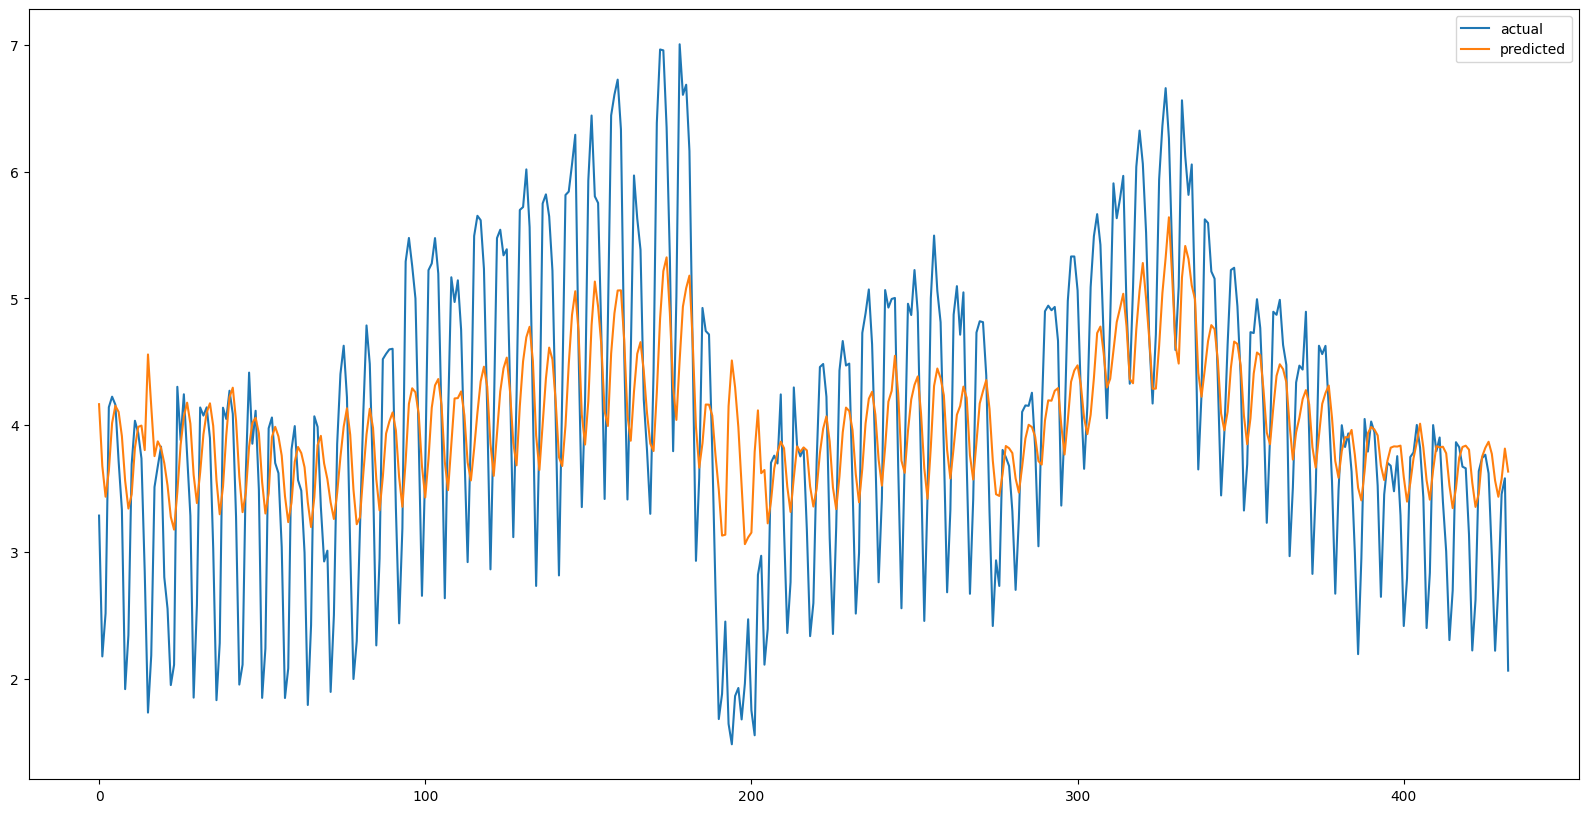

In [ ]:
# Write your code here. Add as many boxes as you need.
plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()

# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to perform a sentiment analysis on a dataset consisting of wine reviews. The dataset contains two attributes: **description** and **points**. The description is a brief text describing the wine and the points which represents a quality metric ranging from 1 to 100. If some wine has at least 90 points it is considered **exceptional**. Your task involves predicting if some wine is exceptional based on its review.

The greater part of the code for the solution is already given. You need to define a tokenizer to tokenize the given texts and a deep neural network model that will be used for the classification task at hand. Fill in only the missing code blocks.

## Requirements

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
import keras
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Downloading the Wine Reviews Dataset

In [ ]:
!gdown 1fz9449M9Owofy6CYrKzkGwXKesI32B8u

Downloading...
From: https://drive.google.com/uc?id=1fz9449M9Owofy6CYrKzkGwXKesI32B8u
To: /content/wine-reviews.csv
100% 32.5M/32.5M [00:00<00:00, 93.0MB/s]


## Exploring the Climate Dataset

Load the dataset into a `pandas` data frame.

In [ ]:
df = pd.read_csv('wine-reviews.csv')

In [ ]:
df.head()

,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


## Feature Extraction

Extract the feature `exceptional` for each wine review.

In [ ]:
df['exceptional'] = df['points'].apply(lambda elem: 1 if elem >= 90 else 0)

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

In [ ]:
X, y = df['description'], df['exceptional']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Text Tokenization

Use tokenizer to convert raw text into a sequence of tokens.

In [ ]:
# Write your code here. Add as many boxes as you need.
max_tokens = 64
tokenizer = Tokenizer(num_words=max_tokens)
tokenizer.fit_on_texts(X_train.values)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

## Padding
Pad each sequence to maximum length of 16.

In [ ]:
# Write your code here. Add as many boxes as you need.
X_train = sequence.pad_sequences(X_train, maxlen=16)
X_test = sequence.pad_sequences(X_test, maxlen=16)

## Deep Neural Network

Define Deep Neural Network model to predict if a specific wine is exceptional or not based on the tokenized and padded wine reviews.

In [ ]:
# Write your code here. Add as many boxes as you need.
num_classes = 1

In [ ]:
model = Sequential()
model.add(Embedding(max_tokens, 32, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='sigmoid'))

Compile the previously defined model specifying loss function, optimizer and evaluation metrics.

In [ ]:
# Write your code here. Add as many boxes as you need.
model.compile(loss=keras.losses.BinaryFocalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

Fit the compiled model on the train set specifying the percent for validation, batch_size, and number of epochs.

In [ ]:
# Write your code here. Add as many boxes as you need.
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=10)

Epoch 1/10
1300/1300 [==============================] - 42s 26ms/step - loss: 0.1505 - precision: 0.6052 - recall: 0.3920 - val_loss: 0.1465 - val_precision: 0.6614 - val_recall: 0.4041
Epoch 2/10
1300/1300 [==============================] - 33s 25ms/step - loss: 0.1455 - precision: 0.6265 - recall: 0.4757 - val_loss: 0.1457 - val_precision: 0.6639 - val_recall: 0.4112
Epoch 3/10
1300/1300 [==============================] - 34s 26ms/step - loss: 0.1435 - precision: 0.6321 - recall: 0.4977 - val_loss: 0.1433 - val_precision: 0.6215 - val_recall: 0.5763
Epoch 4/10
1300/1300 [==============================] - 34s 26ms/step - loss: 0.1419 - precision: 0.6411 - recall: 0.5107 - val_loss: 0.1434 - val_precision: 0.6134 - val_recall: 0.5991
Epoch 5/10
1300/1300 [==============================] - 35s 27ms/step - loss: 0.1408 - precision: 0.6429 - recall: 0.5249 - val_loss: 0.1432 - val_precision: 0.6166 - val_recall: 0.5991
Epoch 6/10
1300/1300 [==============================] - 33s 25ms/step 

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

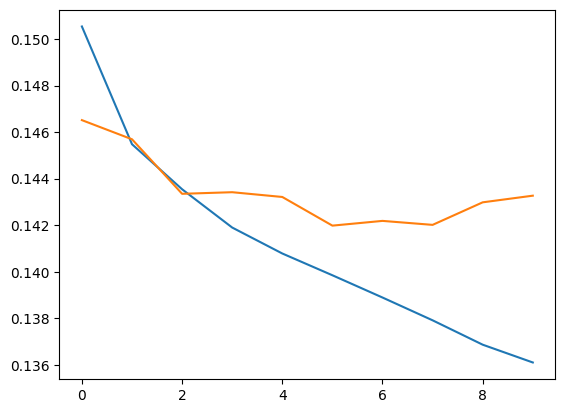

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

Use the trained model to make predictions for the test set.

In [ ]:
y_pred = model.predict(X_test)

813/813 [==============================] - 5s 6ms/step


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
print(classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78     16169
           1       0.65      0.50      0.56      9826

    accuracy                           0.71     25995
   macro avg       0.69      0.67      0.67     25995
weighted avg       0.70      0.71      0.70     25995

